In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.sparse import csr_matrix

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
amt_handler = trainer.AmtTrainHandler()
profile_handler = trainer.AmtProfileHandler()
cnt_handler = trainer.CntTrainHandler()


In [3]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
amt_feats = loader.load_result('2021_12_06_amt_feats.joblib')
cnt_feats = loader.load_result('2021_12_15_cnt_feats.joblib')
amt_feats = amt_feats.astype(np.int64)


In [4]:
non_imp_cates = [
    x for x in amt_handler.shop_cate if x not in amt_handler.ylabels
]
amt_drop_feats = []
cnt_drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        amt_cate_col = "shop_{}_amt_{}".format(non_imp_cate, dt - 24)
        cnt_cate_col = "shop_{}_cnt_{}".format(non_imp_cate, dt - 24)
        amt_drop_feats.append(amt_cate_col)
        cnt_drop_feats.append(cnt_cate_col)

In [5]:
cnt_handler.update_data(cnt_feats)
cnt_handler.train = cnt_handler.train.reset_index(drop=True)
cnt_handler.test = cnt_handler.test.reset_index(drop=True)
cnt_handler.train = cnt_handler.train.drop(cnt_drop_feats, axis=1)
cnt_handler.test = cnt_handler.test.drop(cnt_drop_feats, axis=1)

Start Update Data
Start Processing y label
Start Processing train set
Start Processing test set
Finished updating data


In [6]:
cnt_train = cnt_handler.train.copy()
cnt_test = cnt_handler.test.copy()
cnt_test['dt'] = 25
cnt_train['dt'] = [23] * 500000 + [24] * 500000
ylabels = cnt_handler.y.copy()

In [7]:
amt_handler.update_data(amt_feats)
amt_handler.X = amt_handler.X.drop(amt_drop_feats, axis=1)
amt_handler.test = amt_handler.test.drop(amt_drop_feats, axis=1)
amt_test = amt_handler.test.copy()
amt_train = amt_handler.X.copy()

Start Update Data
Finished updating data


In [8]:
amt_train = amt_train.reset_index(drop=True)
amt_test = amt_test.reset_index(drop=True)

cnt_train = cnt_train.reset_index(drop=True)
cnt_test = cnt_test.reset_index(drop=True)

In [9]:
profile_handler.update_data(profile_feats)
cnt_train = pd.merge(cnt_train, profile_feats, on=['chid', 'dt'], how='left')
cnt_test = pd.merge(cnt_test, profile_feats, on=['chid', 'dt'], how='left')

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [10]:
cnt_train = profile_handler.transform(cnt_train)
cnt_test = profile_handler.transform(cnt_test)

In [11]:
import gc 

del amt_feats
del cnt_feats
del profile_feats
gc.collect()

0

In [12]:
cnt_train = cnt_train.drop(['chid', 'dt'], axis=1)
cnt_test = cnt_test.drop(['chid', 'dt'], axis=1)

amt_train = amt_train.drop(['chid'], axis=1)
amt_test = amt_test.drop(['chid'], axis=1)

In [13]:
cnt_train = pd.concat([cnt_train, amt_train], axis=1)
cnt_test = pd.concat([cnt_test, amt_test], axis=1)

In [14]:
_,_, idx_results = loader.load_result('2021_12_20_amt_train_results.joblib')

In [19]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'poisson',
    'metric': 'poisson',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [16]:
X = cnt_train.copy()
y = ylabels.reset_index(drop=True).copy()

In [17]:
for col in y.columns:
    y[col] = y[col].apply(lambda x: x if x>0 else 0)

Training fold 1


/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/qin/workspace/pydata/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.609459	valid_1's poisson: 0.615381
[100]	training's poisson: 0.511792	valid_1's poisson: 0.519447
[150]	training's poisson: 0.452547	valid_1's poisson: 0.462112
[200]	training's poisson: 0.413533	valid_1's poisson: 0.425196
[250]	training's poisson: 0.386618	valid_1's poisson: 0.400525
[300]	training's poisson: 0.366985	valid_1's poisson: 0.383297
[350]	training's poisson: 0.352218	valid_1's poisson: 0.371081
[400]	training's poisson: 0.340589	valid_1's poisson: 0.362018
[450]	training's poisson: 0.331318	valid_1's poisson: 0.355359
[500]	training's poisson: 0.323905	valid_1's poisson: 0.350565
[550]	training's poisson: 0.317702	valid_1's poisson: 0.347031
[600]	training's poisson: 0.312329	valid_1's poisson: 0.344372
[650]	training's poisson: 0.307668	valid_1's poisson: 0.342299
[700]	training's poisson: 0.30354	valid_1's poisson: 0.340779
[750]	training's poisson: 0.299794	valid_1's poisson: 0.33

<Figure size 864x432 with 0 Axes>

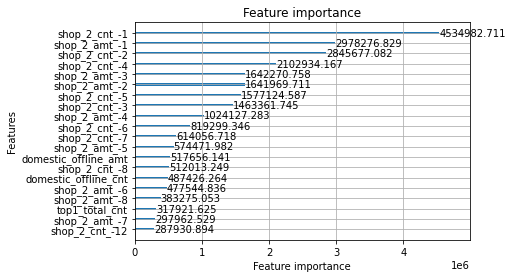

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.228368	valid_1's poisson: 0.230417
[100]	training's poisson: 0.206438	valid_1's poisson: 0.209255
[150]	training's poisson: 0.194024	valid_1's poisson: 0.197728
[200]	training's poisson: 0.185948	valid_1's poisson: 0.19059
[250]	training's poisson: 0.180142	valid_1's poisson: 0.185734
[300]	training's poisson: 0.175823	valid_1's poisson: 0.182419
[350]	training's poisson: 0.172392	valid_1's poisson: 0.180052
[400]	training's poisson: 0.169718	valid_1's poisson: 0.178435
[450]	training's poisson: 0.167435	valid_1's poisson: 0.177194
[500]	training's poisson: 0.165439	valid_1's poisson: 0.176262
[550]	training's poisson: 0.163683	valid_1's poisson: 0.175583
[600]	training's poisson: 0.162082	valid_1's poisson: 0.175047
[650]	training's poisson: 0.160631	valid_1's poisson: 0.174642
[700]	training's poisson: 0.159329	valid_1's poisson: 0.174354
[750]	training's poisson: 0.158135	valid_1's poisson: 0.17

<Figure size 864x432 with 0 Axes>

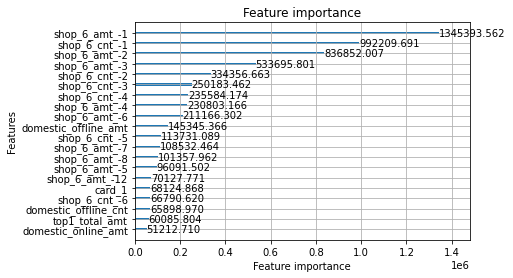

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.475737	valid_1's poisson: 0.489129
[100]	training's poisson: 0.305162	valid_1's poisson: 0.324867
[150]	training's poisson: 0.204958	valid_1's poisson: 0.229891
[200]	training's poisson: 0.138463	valid_1's poisson: 0.168872
[250]	training's poisson: 0.0924652	valid_1's poisson: 0.127645
[300]	training's poisson: 0.0588966	valid_1's poisson: 0.0985438
[350]	training's poisson: 0.0327236	valid_1's poisson: 0.0774666
[400]	training's poisson: 0.012499	valid_1's poisson: 0.0616515
[450]	training's poisson: -0.00371357	valid_1's poisson: 0.049726
[500]	training's poisson: -0.0165154	valid_1's poisson: 0.0408183
[550]	training's poisson: -0.0268602	valid_1's poisson: 0.0343999
[600]	training's poisson: -0.0356248	valid_1's poisson: 0.0295962
[650]	training's poisson: -0.0435788	valid_1's poisson: 0.0255107
[700]	training's poisson: -0.0502664	valid_1's poisson: 0.0224131
[750]	training's poisson: -0.0563

<Figure size 864x432 with 0 Axes>

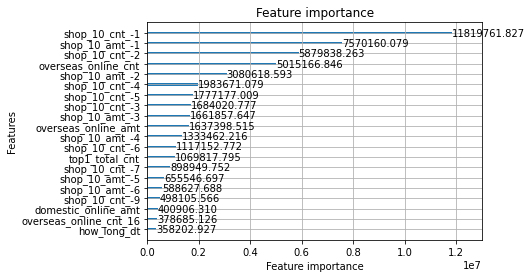

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.344484	valid_1's poisson: 0.347782
[100]	training's poisson: 0.307905	valid_1's poisson: 0.31277
[150]	training's poisson: 0.286563	valid_1's poisson: 0.29276
[200]	training's poisson: 0.27195	valid_1's poisson: 0.279375
[250]	training's poisson: 0.261772	valid_1's poisson: 0.270402
[300]	training's poisson: 0.254334	valid_1's poisson: 0.264189
[350]	training's poisson: 0.248695	valid_1's poisson: 0.259775
[400]	training's poisson: 0.24415	valid_1's poisson: 0.256475
[450]	training's poisson: 0.240549	valid_1's poisson: 0.254158
[500]	training's poisson: 0.237524	valid_1's poisson: 0.25238
[550]	training's poisson: 0.234951	valid_1's poisson: 0.251081
[600]	training's poisson: 0.232678	valid_1's poisson: 0.250076
[650]	training's poisson: 0.230705	valid_1's poisson: 0.249334
[700]	training's poisson: 0.22887	valid_1's poisson: 0.248724
[750]	training's poisson: 0.227194	valid_1's poisson: 0.248257


<Figure size 864x432 with 0 Axes>

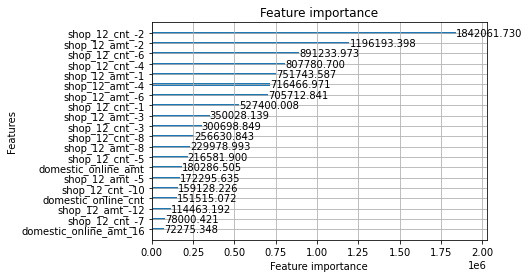

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.306418	valid_1's poisson: 0.308406
[100]	training's poisson: 0.167497	valid_1's poisson: 0.172016
[150]	training's poisson: 0.0859927	valid_1's poisson: 0.0929304
[200]	training's poisson: 0.0345438	valid_1's poisson: 0.0442169
[250]	training's poisson: -0.0032707	valid_1's poisson: 0.00884355
[300]	training's poisson: -0.0307925	valid_1's poisson: -0.0162336
[350]	training's poisson: -0.0517075	valid_1's poisson: -0.0344898
[400]	training's poisson: -0.0676133	valid_1's poisson: -0.0475349
[450]	training's poisson: -0.0806406	valid_1's poisson: -0.0578219
[500]	training's poisson: -0.0912359	valid_1's poisson: -0.0654386
[550]	training's poisson: -0.100134	valid_1's poisson: -0.0715347
[600]	training's poisson: -0.107888	valid_1's poisson: -0.0763888
[650]	training's poisson: -0.114485	valid_1's poisson: -0.0800549
[700]	training's poisson: -0.120513	valid_1's poisson: -0.083203
[750]	training's p

<Figure size 864x432 with 0 Axes>

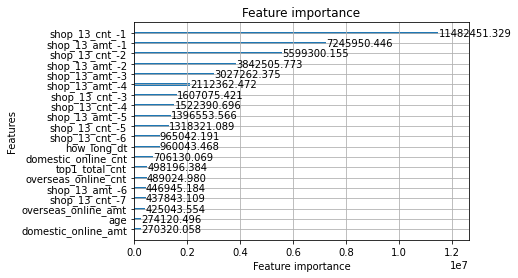

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.538945	valid_1's poisson: 0.547622
[100]	training's poisson: 0.347766	valid_1's poisson: 0.360994
[150]	training's poisson: 0.235154	valid_1's poisson: 0.251712
[200]	training's poisson: 0.163321	valid_1's poisson: 0.182844
[250]	training's poisson: 0.11459	valid_1's poisson: 0.13697
[300]	training's poisson: 0.079535	valid_1's poisson: 0.104689
[350]	training's poisson: 0.0529193	valid_1's poisson: 0.0807033
[400]	training's poisson: 0.0330564	valid_1's poisson: 0.0634269
[450]	training's poisson: 0.0179853	valid_1's poisson: 0.0511128
[500]	training's poisson: 0.00624708	valid_1's poisson: 0.0422988
[550]	training's poisson: -0.00320195	valid_1's poisson: 0.035753
[600]	training's poisson: -0.0109307	valid_1's poisson: 0.0308293
[650]	training's poisson: -0.0174436	valid_1's poisson: 0.0272065
[700]	training's poisson: -0.0231666	valid_1's poisson: 0.0242377
[750]	training's poisson: -0.0283248	v

<Figure size 864x432 with 0 Axes>

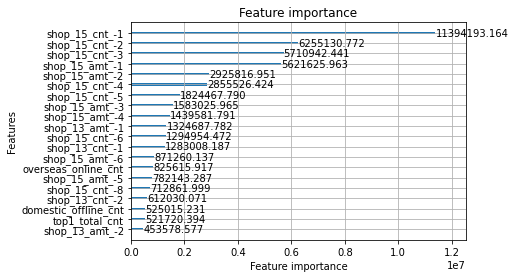

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.264269	valid_1's poisson: 0.267526
[100]	training's poisson: 0.244883	valid_1's poisson: 0.249291
[150]	training's poisson: 0.232914	valid_1's poisson: 0.238543
[200]	training's poisson: 0.224725	valid_1's poisson: 0.231663
[250]	training's poisson: 0.218732	valid_1's poisson: 0.226974
[300]	training's poisson: 0.214108	valid_1's poisson: 0.223681
[350]	training's poisson: 0.210419	valid_1's poisson: 0.221367
[400]	training's poisson: 0.207391	valid_1's poisson: 0.219675
[450]	training's poisson: 0.204789	valid_1's poisson: 0.218406
[500]	training's poisson: 0.202477	valid_1's poisson: 0.217428
[550]	training's poisson: 0.200491	valid_1's poisson: 0.216737
[600]	training's poisson: 0.198717	valid_1's poisson: 0.216192
[650]	training's poisson: 0.197064	valid_1's poisson: 0.215779
[700]	training's poisson: 0.195531	valid_1's poisson: 0.215448
[750]	training's poisson: 0.19415	valid_1's poisson: 0.21

<Figure size 864x432 with 0 Axes>

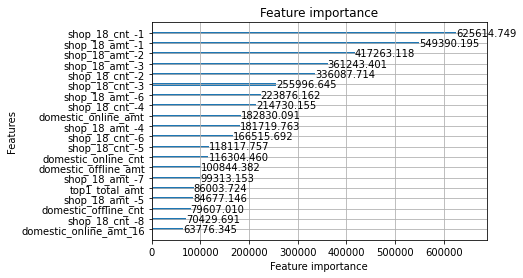

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.375214	valid_1's poisson: 0.376529
[100]	training's poisson: 0.352261	valid_1's poisson: 0.355898
[150]	training's poisson: 0.337725	valid_1's poisson: 0.343337
[200]	training's poisson: 0.327481	valid_1's poisson: 0.335047
[250]	training's poisson: 0.319907	valid_1's poisson: 0.329323
[300]	training's poisson: 0.314051	valid_1's poisson: 0.325259
[350]	training's poisson: 0.309305	valid_1's poisson: 0.322306
[400]	training's poisson: 0.305356	valid_1's poisson: 0.320146
[450]	training's poisson: 0.302024	valid_1's poisson: 0.318493
[500]	training's poisson: 0.299137	valid_1's poisson: 0.317267
[550]	training's poisson: 0.296537	valid_1's poisson: 0.316301
[600]	training's poisson: 0.29424	valid_1's poisson: 0.315583
[650]	training's poisson: 0.292112	valid_1's poisson: 0.315019
[700]	training's poisson: 0.290168	valid_1's poisson: 0.314585
[750]	training's poisson: 0.28842	valid_1's poisson: 0.314

<Figure size 864x432 with 0 Axes>

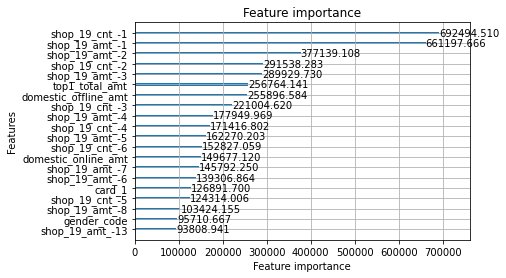

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.289341	valid_1's poisson: 0.292562
[100]	training's poisson: 0.269895	valid_1's poisson: 0.275402
[150]	training's poisson: 0.25762	valid_1's poisson: 0.265294
[200]	training's poisson: 0.248881	valid_1's poisson: 0.258553
[250]	training's poisson: 0.242396	valid_1's poisson: 0.254033
[300]	training's poisson: 0.237239	valid_1's poisson: 0.250765
[350]	training's poisson: 0.233049	valid_1's poisson: 0.248419
[400]	training's poisson: 0.229492	valid_1's poisson: 0.246696
[450]	training's poisson: 0.226419	valid_1's poisson: 0.245407
[500]	training's poisson: 0.223714	valid_1's poisson: 0.244476
[550]	training's poisson: 0.221355	valid_1's poisson: 0.243773
[600]	training's poisson: 0.21915	valid_1's poisson: 0.243208
[650]	training's poisson: 0.217203	valid_1's poisson: 0.242794
[700]	training's poisson: 0.215389	valid_1's poisson: 0.242441
[750]	training's poisson: 0.21374	valid_1's poisson: 0.2421

<Figure size 864x432 with 0 Axes>

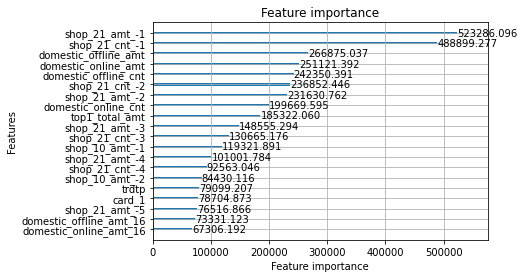

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.232525	valid_1's poisson: 0.237169
[100]	training's poisson: 0.21227	valid_1's poisson: 0.218402
[150]	training's poisson: 0.200056	valid_1's poisson: 0.207522
[200]	training's poisson: 0.191787	valid_1's poisson: 0.200537
[250]	training's poisson: 0.185743	valid_1's poisson: 0.195721
[300]	training's poisson: 0.181131	valid_1's poisson: 0.192341
[350]	training's poisson: 0.177483	valid_1's poisson: 0.189951
[400]	training's poisson: 0.174559	valid_1's poisson: 0.188226
[450]	training's poisson: 0.172068	valid_1's poisson: 0.186886
[500]	training's poisson: 0.169923	valid_1's poisson: 0.185929
[550]	training's poisson: 0.168034	valid_1's poisson: 0.185215
[600]	training's poisson: 0.166331	valid_1's poisson: 0.18466
[650]	training's poisson: 0.164716	valid_1's poisson: 0.184235
[700]	training's poisson: 0.163274	valid_1's poisson: 0.183909
[750]	training's poisson: 0.161969	valid_1's poisson: 0.183

<Figure size 864x432 with 0 Axes>

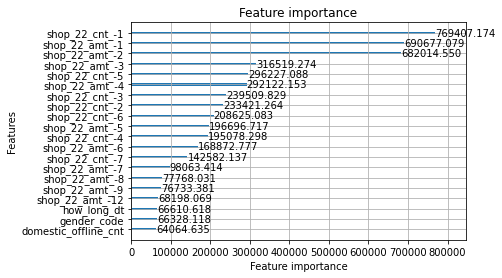

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.289638	valid_1's poisson: 0.290864
[100]	training's poisson: 0.265409	valid_1's poisson: 0.268468
[150]	training's poisson: 0.250884	valid_1's poisson: 0.255528
[200]	training's poisson: 0.240809	valid_1's poisson: 0.2469
[250]	training's poisson: 0.233401	valid_1's poisson: 0.240879
[300]	training's poisson: 0.227748	valid_1's poisson: 0.236596
[350]	training's poisson: 0.223314	valid_1's poisson: 0.233535
[400]	training's poisson: 0.219763	valid_1's poisson: 0.231354
[450]	training's poisson: 0.216768	valid_1's poisson: 0.229694
[500]	training's poisson: 0.214208	valid_1's poisson: 0.228496
[550]	training's poisson: 0.21193	valid_1's poisson: 0.227571
[600]	training's poisson: 0.209899	valid_1's poisson: 0.226872
[650]	training's poisson: 0.208058	valid_1's poisson: 0.226353
[700]	training's poisson: 0.206372	valid_1's poisson: 0.225931
[750]	training's poisson: 0.204851	valid_1's poisson: 0.2256

<Figure size 864x432 with 0 Axes>

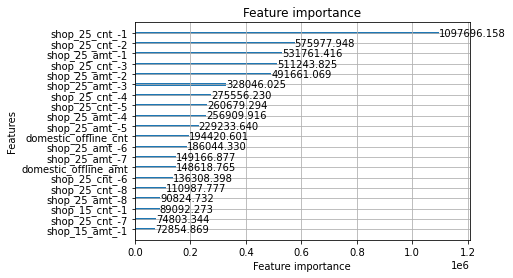

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.192026	valid_1's poisson: 0.193746
[100]	training's poisson: 0.174613	valid_1's poisson: 0.177843
[150]	training's poisson: 0.164252	valid_1's poisson: 0.168863
[200]	training's poisson: 0.157298	valid_1's poisson: 0.16325
[250]	training's poisson: 0.152361	valid_1's poisson: 0.159626
[300]	training's poisson: 0.148541	valid_1's poisson: 0.157147
[350]	training's poisson: 0.14541	valid_1's poisson: 0.155276
[400]	training's poisson: 0.142829	valid_1's poisson: 0.153897
[450]	training's poisson: 0.1406	valid_1's poisson: 0.15288
[500]	training's poisson: 0.138629	valid_1's poisson: 0.152148
[550]	training's poisson: 0.136982	valid_1's poisson: 0.15164
[600]	training's poisson: 0.135411	valid_1's poisson: 0.151243
[650]	training's poisson: 0.133959	valid_1's poisson: 0.150953
[700]	training's poisson: 0.132591	valid_1's poisson: 0.150753
[750]	training's poisson: 0.131326	valid_1's poisson: 0.150583


<Figure size 864x432 with 0 Axes>

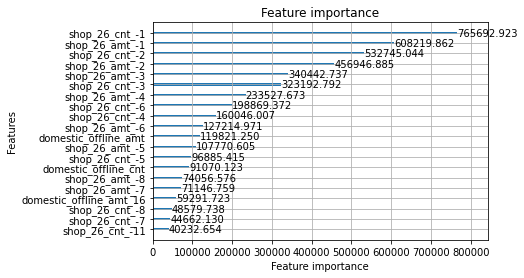

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.0267931	valid_1's poisson: 0.0216333
[100]	training's poisson: -0.334439	valid_1's poisson: -0.337288
[150]	training's poisson: -0.542671	valid_1's poisson: -0.542511
[200]	training's poisson: -0.676496	valid_1's poisson: -0.673075
[250]	training's poisson: -0.772463	valid_1's poisson: -0.766019
[300]	training's poisson: -0.840023	valid_1's poisson: -0.830446
[350]	training's poisson: -0.890244	valid_1's poisson: -0.877519
[400]	training's poisson: -0.927915	valid_1's poisson: -0.912088
[450]	training's poisson: -0.957155	valid_1's poisson: -0.938217
[500]	training's poisson: -0.980241	valid_1's poisson: -0.958214
[550]	training's poisson: -0.99789	valid_1's poisson: -0.972679
[600]	training's poisson: -1.0121	valid_1's poisson: -0.983766
[650]	training's poisson: -1.02379	valid_1's poisson: -0.992453
[700]	training's poisson: -1.0334	valid_1's poisson: -0.998942
[750]	training's poisson: -1.04117	

<Figure size 864x432 with 0 Axes>

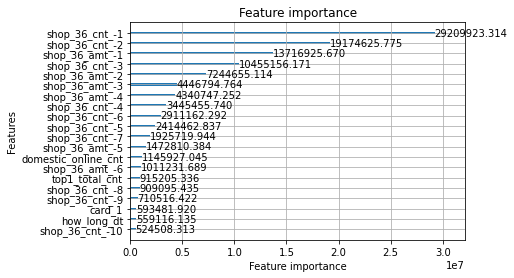

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.598517	valid_1's poisson: 0.610728
[100]	training's poisson: 0.412793	valid_1's poisson: 0.429973
[150]	training's poisson: 0.305788	valid_1's poisson: 0.326553
[200]	training's poisson: 0.233037	valid_1's poisson: 0.256768
[250]	training's poisson: 0.182989	valid_1's poisson: 0.209436
[300]	training's poisson: 0.148065	valid_1's poisson: 0.177171
[350]	training's poisson: 0.121386	valid_1's poisson: 0.152977
[400]	training's poisson: 0.102152	valid_1's poisson: 0.136314
[450]	training's poisson: 0.0866262	valid_1's poisson: 0.123254
[500]	training's poisson: 0.0749532	valid_1's poisson: 0.114106
[550]	training's poisson: 0.0654901	valid_1's poisson: 0.107079
[600]	training's poisson: 0.0577547	valid_1's poisson: 0.101834
[650]	training's poisson: 0.0510406	valid_1's poisson: 0.097521
[700]	training's poisson: 0.0453896	valid_1's poisson: 0.0942212
[750]	training's poisson: 0.0402583	valid_1's pois

<Figure size 864x432 with 0 Axes>

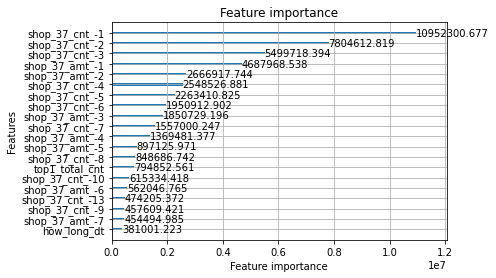

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.208204	valid_1's poisson: 0.213667
[100]	training's poisson: 0.193089	valid_1's poisson: 0.200212
[150]	training's poisson: 0.183429	valid_1's poisson: 0.192084
[200]	training's poisson: 0.17653	valid_1's poisson: 0.186686
[250]	training's poisson: 0.17138	valid_1's poisson: 0.183005
[300]	training's poisson: 0.167281	valid_1's poisson: 0.180323
[350]	training's poisson: 0.164009	valid_1's poisson: 0.178443
[400]	training's poisson: 0.16123	valid_1's poisson: 0.177056
[450]	training's poisson: 0.158858	valid_1's poisson: 0.176011
[500]	training's poisson: 0.156813	valid_1's poisson: 0.175264
[550]	training's poisson: 0.154947	valid_1's poisson: 0.174676
[600]	training's poisson: 0.15329	valid_1's poisson: 0.174212
[650]	training's poisson: 0.151773	valid_1's poisson: 0.173875
[700]	training's poisson: 0.150381	valid_1's poisson: 0.173631
[750]	training's poisson: 0.149087	valid_1's poisson: 0.17344

<Figure size 864x432 with 0 Axes>

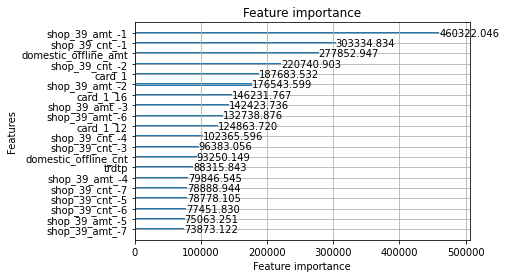

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.509551	valid_1's poisson: 0.511403
[100]	training's poisson: 0.405833	valid_1's poisson: 0.410536
[150]	training's poisson: 0.342921	valid_1's poisson: 0.350101
[200]	training's poisson: 0.3019	valid_1's poisson: 0.311356
[250]	training's poisson: 0.273921	valid_1's poisson: 0.285707
[300]	training's poisson: 0.253639	valid_1's poisson: 0.267731
[350]	training's poisson: 0.238321	valid_1's poisson: 0.254724
[400]	training's poisson: 0.226471	valid_1's poisson: 0.245177
[450]	training's poisson: 0.21747	valid_1's poisson: 0.238567
[500]	training's poisson: 0.210091	valid_1's poisson: 0.233543
[550]	training's poisson: 0.203712	valid_1's poisson: 0.229433
[600]	training's poisson: 0.198383	valid_1's poisson: 0.226343
[650]	training's poisson: 0.193827	valid_1's poisson: 0.22403
[700]	training's poisson: 0.189863	valid_1's poisson: 0.222291
[750]	training's poisson: 0.186389	valid_1's poisson: 0.22102

<Figure size 864x432 with 0 Axes>

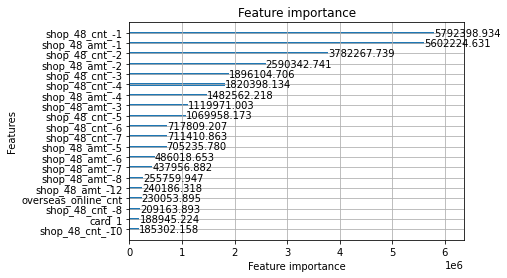

Training fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.611272	valid_1's poisson: 0.613254
[100]	training's poisson: 0.511058	valid_1's poisson: 0.516472
[150]	training's poisson: 0.451527	valid_1's poisson: 0.460035
[200]	training's poisson: 0.413168	valid_1's poisson: 0.424633
[250]	training's poisson: 0.386146	valid_1's poisson: 0.40043
[300]	training's poisson: 0.366289	valid_1's poisson: 0.383374
[350]	training's poisson: 0.351509	valid_1's poisson: 0.371365
[400]	training's poisson: 0.339909	valid_1's poisson: 0.362545
[450]	training's poisson: 0.33087	valid_1's poisson: 0.356305
[500]	training's poisson: 0.323432	valid_1's poisson: 0.35166
[550]	training's poisson: 0.317138	valid_1's poisson: 0.348105
[600]	training's poisson: 0.311807	valid_1's poisson: 0.345444
[650]	training's poisson: 0.307087	valid_1's poisson: 0.343426
[700]	training's poisson: 0.30288	valid_1's poisson: 0.341864
[750]	training's poisson: 0.298958	valid_1's 

<Figure size 864x432 with 0 Axes>

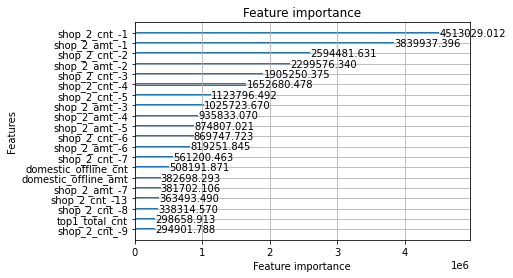

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.228652	valid_1's poisson: 0.228785
[100]	training's poisson: 0.206821	valid_1's poisson: 0.20808
[150]	training's poisson: 0.194363	valid_1's poisson: 0.196756
[200]	training's poisson: 0.186233	valid_1's poisson: 0.189745
[250]	training's poisson: 0.180423	valid_1's poisson: 0.185086
[300]	training's poisson: 0.176047	valid_1's poisson: 0.181907
[350]	training's poisson: 0.172602	valid_1's poisson: 0.179646
[400]	training's poisson: 0.169818	valid_1's poisson: 0.178001
[450]	training's poisson: 0.167486	valid_1's poisson: 0.176807
[500]	training's poisson: 0.165523	valid_1's poisson: 0.175931
[550]	training's poisson: 0.163756	valid_1's poisson: 0.175286
[600]	training's poisson: 0.162177	valid_1's poisson: 0.174781
[650]	training's poisson: 0.160716	valid_1's poisson: 0.174387
[700]	training's poisson: 0.159329	valid_1's poisson: 0.174079
[750]	training's poisson: 0.158113	valid_1's poisson: 0.17

<Figure size 864x432 with 0 Axes>

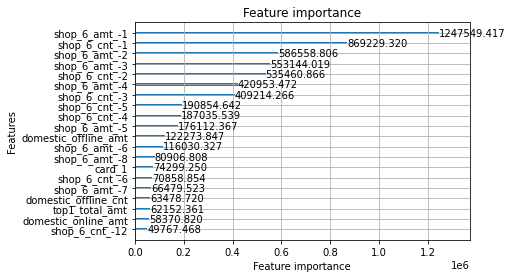

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.471446	valid_1's poisson: 0.487794
[100]	training's poisson: 0.300719	valid_1's poisson: 0.325479
[150]	training's poisson: 0.201154	valid_1's poisson: 0.232791
[200]	training's poisson: 0.135245	valid_1's poisson: 0.172674
[250]	training's poisson: 0.0894985	valid_1's poisson: 0.132094
[300]	training's poisson: 0.0547023	valid_1's poisson: 0.102709
[350]	training's poisson: 0.0284206	valid_1's poisson: 0.0811488
[400]	training's poisson: 0.00792987	valid_1's poisson: 0.0649828
[450]	training's poisson: -0.00807385	valid_1's poisson: 0.0533812
[500]	training's poisson: -0.0207794	valid_1's poisson: 0.0448916
[550]	training's poisson: -0.0315706	valid_1's poisson: 0.0382917
[600]	training's poisson: -0.0406493	valid_1's poisson: 0.0334264
[650]	training's poisson: -0.0484412	valid_1's poisson: 0.0295733
[700]	training's poisson: -0.0552588	valid_1's poisson: 0.0267449
[750]	training's poisson: -0.06

<Figure size 864x432 with 0 Axes>

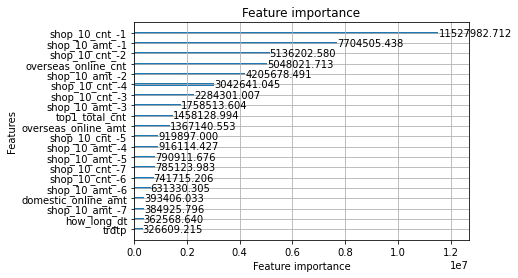

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.345807	valid_1's poisson: 0.347174
[100]	training's poisson: 0.309204	valid_1's poisson: 0.311299
[150]	training's poisson: 0.287124	valid_1's poisson: 0.290088
[200]	training's poisson: 0.272797	valid_1's poisson: 0.276772
[250]	training's poisson: 0.262709	valid_1's poisson: 0.267721
[300]	training's poisson: 0.255276	valid_1's poisson: 0.261379
[350]	training's poisson: 0.249751	valid_1's poisson: 0.257003
[400]	training's poisson: 0.245295	valid_1's poisson: 0.253708
[450]	training's poisson: 0.241726	valid_1's poisson: 0.251331
[500]	training's poisson: 0.23878	valid_1's poisson: 0.249591
[550]	training's poisson: 0.23625	valid_1's poisson: 0.2483
[600]	training's poisson: 0.23403	valid_1's poisson: 0.247278
[650]	training's poisson: 0.232079	valid_1's poisson: 0.246519
[700]	training's poisson: 0.23029	valid_1's poisson: 0.245889
[750]	training's poisson: 0.2287	valid_1's poisson: 0.245446
[8

<Figure size 864x432 with 0 Axes>

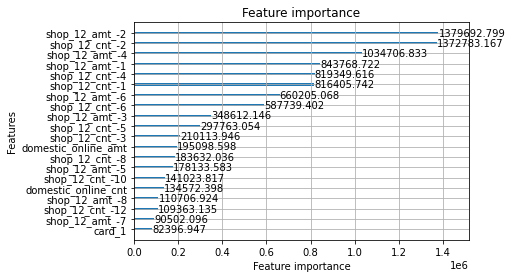

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.311638	valid_1's poisson: 0.316022
[100]	training's poisson: 0.168592	valid_1's poisson: 0.176894
[150]	training's poisson: 0.0857861	valid_1's poisson: 0.0975166
[200]	training's poisson: 0.0311004	valid_1's poisson: 0.0460562
[250]	training's poisson: -0.00654477	valid_1's poisson: 0.0115759
[300]	training's poisson: -0.0340711	valid_1's poisson: -0.0129224
[350]	training's poisson: -0.0551274	valid_1's poisson: -0.0309881
[400]	training's poisson: -0.0711337	valid_1's poisson: -0.0438356
[450]	training's poisson: -0.0838942	valid_1's poisson: -0.0534223
[500]	training's poisson: -0.0948636	valid_1's poisson: -0.061449
[550]	training's poisson: -0.103951	valid_1's poisson: -0.0675119
[600]	training's poisson: -0.111621	valid_1's poisson: -0.072012
[650]	training's poisson: -0.118255	valid_1's poisson: -0.0756041
[700]	training's poisson: -0.124251	valid_1's poisson: -0.0784541
[750]	training's po

<Figure size 864x432 with 0 Axes>

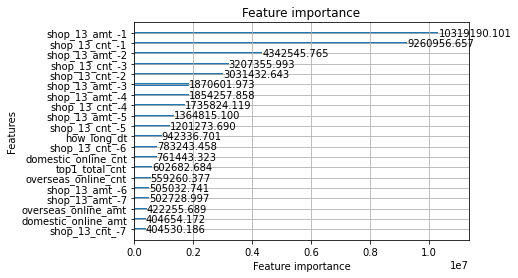

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.546451	valid_1's poisson: 0.544978
[100]	training's poisson: 0.357488	valid_1's poisson: 0.35752
[150]	training's poisson: 0.244759	valid_1's poisson: 0.246971
[200]	training's poisson: 0.171174	valid_1's poisson: 0.175881
[250]	training's poisson: 0.120601	valid_1's poisson: 0.12804
[300]	training's poisson: 0.085195	valid_1's poisson: 0.0955078
[350]	training's poisson: 0.0587681	valid_1's poisson: 0.0719493
[400]	training's poisson: 0.0394362	valid_1's poisson: 0.0556345
[450]	training's poisson: 0.0240257	valid_1's poisson: 0.0432445
[500]	training's poisson: 0.0119123	valid_1's poisson: 0.0341386
[550]	training's poisson: 0.00237964	valid_1's poisson: 0.0276605
[600]	training's poisson: -0.00558188	valid_1's poisson: 0.0227793
[650]	training's poisson: -0.0120926	valid_1's poisson: 0.0193516
[700]	training's poisson: -0.0179473	valid_1's poisson: 0.0164545
[750]	training's poisson: -0.0231384	

<Figure size 864x432 with 0 Axes>

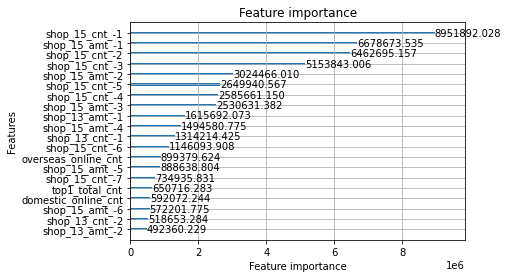

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.263841	valid_1's poisson: 0.26799
[100]	training's poisson: 0.244058	valid_1's poisson: 0.250183
[150]	training's poisson: 0.232225	valid_1's poisson: 0.240031
[200]	training's poisson: 0.223945	valid_1's poisson: 0.233325
[250]	training's poisson: 0.217868	valid_1's poisson: 0.228795
[300]	training's poisson: 0.213238	valid_1's poisson: 0.225621
[350]	training's poisson: 0.20948	valid_1's poisson: 0.223291
[400]	training's poisson: 0.206346	valid_1's poisson: 0.221585
[450]	training's poisson: 0.203764	valid_1's poisson: 0.220371
[500]	training's poisson: 0.201466	valid_1's poisson: 0.219452
[550]	training's poisson: 0.199416	valid_1's poisson: 0.218751
[600]	training's poisson: 0.197591	valid_1's poisson: 0.218209
[650]	training's poisson: 0.195906	valid_1's poisson: 0.217795
[700]	training's poisson: 0.194393	valid_1's poisson: 0.217475
[750]	training's poisson: 0.192987	valid_1's poisson: 0.217

<Figure size 864x432 with 0 Axes>

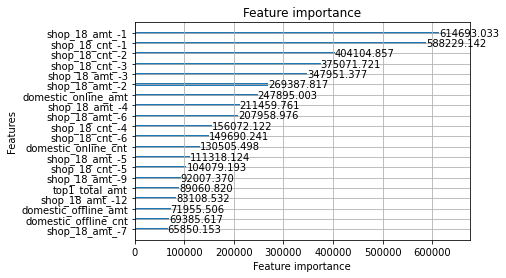

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.374515	valid_1's poisson: 0.378013
[100]	training's poisson: 0.351627	valid_1's poisson: 0.357165
[150]	training's poisson: 0.337128	valid_1's poisson: 0.344501
[200]	training's poisson: 0.327036	valid_1's poisson: 0.336208
[250]	training's poisson: 0.319505	valid_1's poisson: 0.330411
[300]	training's poisson: 0.313668	valid_1's poisson: 0.326314
[350]	training's poisson: 0.308967	valid_1's poisson: 0.323359
[400]	training's poisson: 0.30509	valid_1's poisson: 0.32116
[450]	training's poisson: 0.301803	valid_1's poisson: 0.319504
[500]	training's poisson: 0.298958	valid_1's poisson: 0.318264
[550]	training's poisson: 0.296308	valid_1's poisson: 0.317268
[600]	training's poisson: 0.29404	valid_1's poisson: 0.316515
[650]	training's poisson: 0.291947	valid_1's poisson: 0.315939
[700]	training's poisson: 0.289952	valid_1's poisson: 0.315466
[750]	training's poisson: 0.288156	valid_1's poisson: 0.3151

<Figure size 864x432 with 0 Axes>

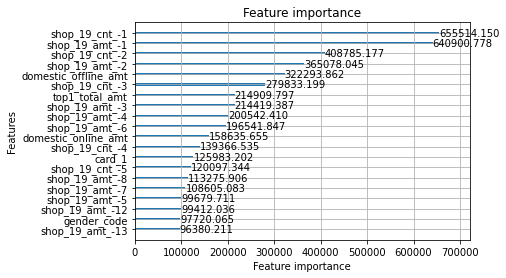

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.289447	valid_1's poisson: 0.292219
[100]	training's poisson: 0.269866	valid_1's poisson: 0.275351
[150]	training's poisson: 0.257506	valid_1's poisson: 0.265409
[200]	training's poisson: 0.248562	valid_1's poisson: 0.258715
[250]	training's poisson: 0.241937	valid_1's poisson: 0.254295
[300]	training's poisson: 0.236641	valid_1's poisson: 0.251105
[350]	training's poisson: 0.232318	valid_1's poisson: 0.248857
[400]	training's poisson: 0.228753	valid_1's poisson: 0.247243
[450]	training's poisson: 0.22565	valid_1's poisson: 0.246035
[500]	training's poisson: 0.222911	valid_1's poisson: 0.245174
[550]	training's poisson: 0.220442	valid_1's poisson: 0.24451
[600]	training's poisson: 0.218244	valid_1's poisson: 0.244043
[650]	training's poisson: 0.216214	valid_1's poisson: 0.243669
[700]	training's poisson: 0.214383	valid_1's poisson: 0.243375
[750]	training's poisson: 0.212737	valid_1's poisson: 0.243

<Figure size 864x432 with 0 Axes>

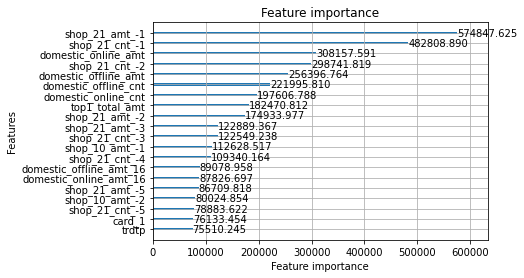

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.23302	valid_1's poisson: 0.23504
[100]	training's poisson: 0.212701	valid_1's poisson: 0.216248
[150]	training's poisson: 0.200465	valid_1's poisson: 0.205348
[200]	training's poisson: 0.19221	valid_1's poisson: 0.19832
[250]	training's poisson: 0.186266	valid_1's poisson: 0.193566
[300]	training's poisson: 0.181745	valid_1's poisson: 0.190199
[350]	training's poisson: 0.178235	valid_1's poisson: 0.187856
[400]	training's poisson: 0.175351	valid_1's poisson: 0.186126
[450]	training's poisson: 0.172953	valid_1's poisson: 0.184873
[500]	training's poisson: 0.17085	valid_1's poisson: 0.18393
[550]	training's poisson: 0.169006	valid_1's poisson: 0.183238
[600]	training's poisson: 0.167321	valid_1's poisson: 0.182665
[650]	training's poisson: 0.165777	valid_1's poisson: 0.182254
[700]	training's poisson: 0.164332	valid_1's poisson: 0.181905
[750]	training's poisson: 0.163007	valid_1's poisson: 0.181627


<Figure size 864x432 with 0 Axes>

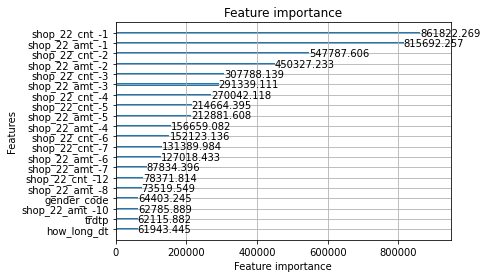

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.288841	valid_1's poisson: 0.291181
[100]	training's poisson: 0.264302	valid_1's poisson: 0.268738
[150]	training's poisson: 0.249623	valid_1's poisson: 0.25588
[200]	training's poisson: 0.239578	valid_1's poisson: 0.247503
[250]	training's poisson: 0.232262	valid_1's poisson: 0.241732
[300]	training's poisson: 0.226689	valid_1's poisson: 0.237652
[350]	training's poisson: 0.222304	valid_1's poisson: 0.234704
[400]	training's poisson: 0.218722	valid_1's poisson: 0.232583
[450]	training's poisson: 0.215749	valid_1's poisson: 0.231055
[500]	training's poisson: 0.213124	valid_1's poisson: 0.229833
[550]	training's poisson: 0.210856	valid_1's poisson: 0.228966
[600]	training's poisson: 0.208789	valid_1's poisson: 0.228294
[650]	training's poisson: 0.20695	valid_1's poisson: 0.227775
[700]	training's poisson: 0.205295	valid_1's poisson: 0.227397
[750]	training's poisson: 0.203737	valid_1's poisson: 0.227

<Figure size 864x432 with 0 Axes>

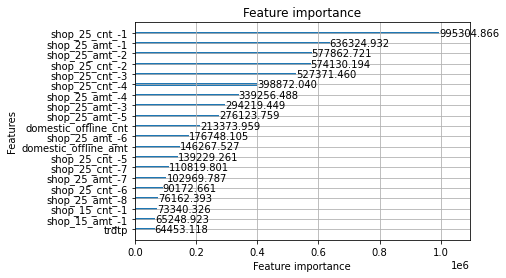

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.19214	valid_1's poisson: 0.192427
[100]	training's poisson: 0.175003	valid_1's poisson: 0.176851
[150]	training's poisson: 0.164578	valid_1's poisson: 0.1678
[200]	training's poisson: 0.157643	valid_1's poisson: 0.162156
[250]	training's poisson: 0.152722	valid_1's poisson: 0.1585
[300]	training's poisson: 0.148873	valid_1's poisson: 0.155905
[350]	training's poisson: 0.145837	valid_1's poisson: 0.154107
[400]	training's poisson: 0.14326	valid_1's poisson: 0.152717
[450]	training's poisson: 0.141038	valid_1's poisson: 0.151677
[500]	training's poisson: 0.139146	valid_1's poisson: 0.151021
[550]	training's poisson: 0.137418	valid_1's poisson: 0.15046
[600]	training's poisson: 0.135867	valid_1's poisson: 0.150083
[650]	training's poisson: 0.134385	valid_1's poisson: 0.149765
[700]	training's poisson: 0.133082	valid_1's poisson: 0.14953
[750]	training's poisson: 0.131818	valid_1's poisson: 0.149343
[8

<Figure size 864x432 with 0 Axes>

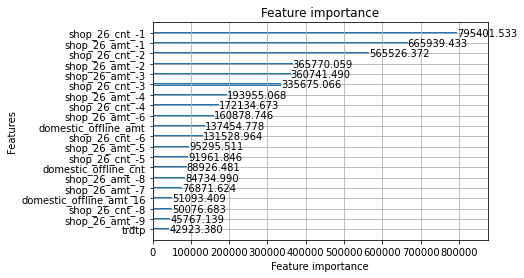

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.032194	valid_1's poisson: 0.0514369
[100]	training's poisson: -0.33071	valid_1's poisson: -0.305368
[150]	training's poisson: -0.540768	valid_1's poisson: -0.511569
[200]	training's poisson: -0.680048	valid_1's poisson: -0.647634
[250]	training's poisson: -0.777253	valid_1's poisson: -0.741966
[300]	training's poisson: -0.846729	valid_1's poisson: -0.808738
[350]	training's poisson: -0.897354	valid_1's poisson: -0.856538
[400]	training's poisson: -0.935128	valid_1's poisson: -0.891405
[450]	training's poisson: -0.964181	valid_1's poisson: -0.917493
[500]	training's poisson: -0.986468	valid_1's poisson: -0.936751
[550]	training's poisson: -1.00403	valid_1's poisson: -0.951198
[600]	training's poisson: -1.01882	valid_1's poisson: -0.963055
[650]	training's poisson: -1.03077	valid_1's poisson: -0.972085
[700]	training's poisson: -1.04044	valid_1's poisson: -0.978615
[750]	training's poisson: -1.04869	

<Figure size 864x432 with 0 Axes>

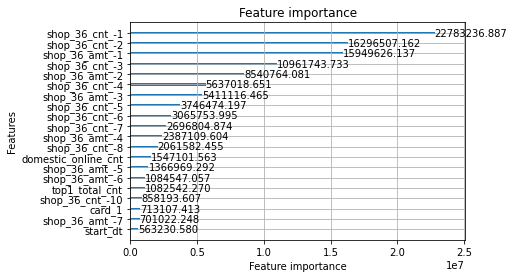

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.612497	valid_1's poisson: 0.612088
[100]	training's poisson: 0.428406	valid_1's poisson: 0.429291
[150]	training's poisson: 0.31692	valid_1's poisson: 0.319455
[200]	training's poisson: 0.24468	valid_1's poisson: 0.248988
[250]	training's poisson: 0.194329	valid_1's poisson: 0.20048
[300]	training's poisson: 0.157312	valid_1's poisson: 0.165276
[350]	training's poisson: 0.131628	valid_1's poisson: 0.141683
[400]	training's poisson: 0.110816	valid_1's poisson: 0.122947
[450]	training's poisson: 0.0954841	valid_1's poisson: 0.109752
[500]	training's poisson: 0.0840083	valid_1's poisson: 0.100509
[550]	training's poisson: 0.0745075	valid_1's poisson: 0.0932359
[600]	training's poisson: 0.0666133	valid_1's poisson: 0.0875398
[650]	training's poisson: 0.0597451	valid_1's poisson: 0.0827938
[700]	training's poisson: 0.054142	valid_1's poisson: 0.0793878
[750]	training's poisson: 0.0496243	valid_1's poiss

<Figure size 864x432 with 0 Axes>

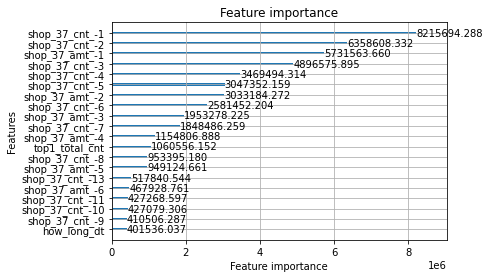

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.209719	valid_1's poisson: 0.210363
[100]	training's poisson: 0.194445	valid_1's poisson: 0.197047
[150]	training's poisson: 0.184621	valid_1's poisson: 0.188925
[200]	training's poisson: 0.177722	valid_1's poisson: 0.183612
[250]	training's poisson: 0.172621	valid_1's poisson: 0.180022
[300]	training's poisson: 0.168539	valid_1's poisson: 0.177466
[350]	training's poisson: 0.165225	valid_1's poisson: 0.175599
[400]	training's poisson: 0.162417	valid_1's poisson: 0.17419
[450]	training's poisson: 0.160073	valid_1's poisson: 0.173161
[500]	training's poisson: 0.158012	valid_1's poisson: 0.172395
[550]	training's poisson: 0.156195	valid_1's poisson: 0.171815
[600]	training's poisson: 0.154538	valid_1's poisson: 0.171385
[650]	training's poisson: 0.153025	valid_1's poisson: 0.171042
[700]	training's poisson: 0.151713	valid_1's poisson: 0.170791
[750]	training's poisson: 0.150447	valid_1's poisson: 0.17

<Figure size 864x432 with 0 Axes>

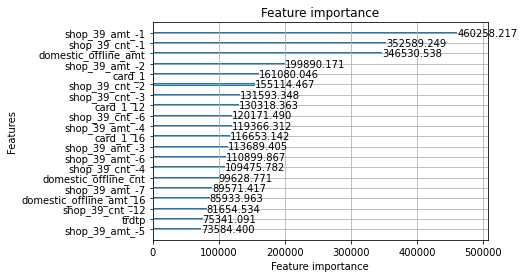

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.510131	valid_1's poisson: 0.509578
[100]	training's poisson: 0.404179	valid_1's poisson: 0.403282
[150]	training's poisson: 0.344374	valid_1's poisson: 0.344512
[200]	training's poisson: 0.304099	valid_1's poisson: 0.30564
[250]	training's poisson: 0.276897	valid_1's poisson: 0.280258
[300]	training's poisson: 0.256796	valid_1's poisson: 0.262067
[350]	training's poisson: 0.241303	valid_1's poisson: 0.248515
[400]	training's poisson: 0.229671	valid_1's poisson: 0.238874
[450]	training's poisson: 0.22045	valid_1's poisson: 0.231694
[500]	training's poisson: 0.213014	valid_1's poisson: 0.226353
[550]	training's poisson: 0.206874	valid_1's poisson: 0.222343
[600]	training's poisson: 0.201697	valid_1's poisson: 0.219269
[650]	training's poisson: 0.197248	valid_1's poisson: 0.216939
[700]	training's poisson: 0.193282	valid_1's poisson: 0.215128
[750]	training's poisson: 0.189799	valid_1's poisson: 0.213

<Figure size 864x432 with 0 Axes>

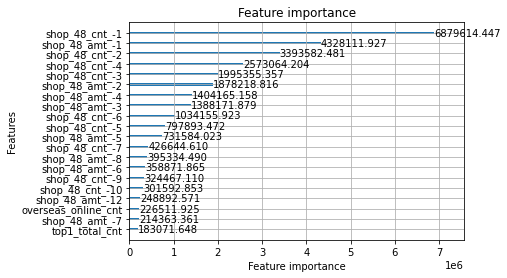

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.607251	valid_1's poisson: 0.612525
[100]	training's poisson: 0.508935	valid_1's poisson: 0.518869
[150]	training's poisson: 0.449269	valid_1's poisson: 0.462912
[200]	training's poisson: 0.410353	valid_1's poisson: 0.427379
[250]	training's poisson: 0.383331	valid_1's poisson: 0.403472
[300]	training's poisson: 0.363772	valid_1's poisson: 0.386947
[350]	training's poisson: 0.348911	valid_1's poisson: 0.375027
[400]	training's poisson: 0.337343	valid_1's poisson: 0.366374
[450]	training's poisson: 0.328259	valid_1's poisson: 0.360209
[500]	training's poisson: 0.320762	valid_1's poisson: 0.355546
[550]	training's poisson: 0.314617	valid_1's poisson: 0.35219
[600]	training's poisson: 0.309083	valid_1's poisson: 0.349493
[650]	training's poisson: 0.304447	valid_1's poisson: 0.347524
[700]	training's poisson: 0.300152	valid_1's poisson: 0.345916
[750]	training's poisson: 0.29639	valid_1'

<Figure size 864x432 with 0 Axes>

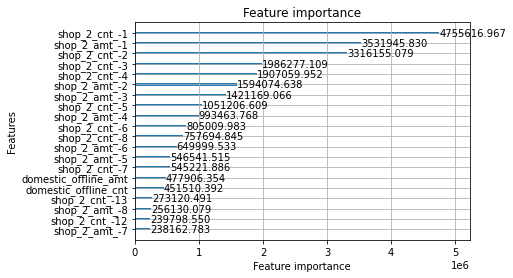

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.228031	valid_1's poisson: 0.230069
[100]	training's poisson: 0.205847	valid_1's poisson: 0.209526
[150]	training's poisson: 0.193317	valid_1's poisson: 0.198431
[200]	training's poisson: 0.185104	valid_1's poisson: 0.191557
[250]	training's poisson: 0.17924	valid_1's poisson: 0.186971
[300]	training's poisson: 0.174912	valid_1's poisson: 0.183881
[350]	training's poisson: 0.171429	valid_1's poisson: 0.181649
[400]	training's poisson: 0.168626	valid_1's poisson: 0.180043
[450]	training's poisson: 0.166281	valid_1's poisson: 0.178886
[500]	training's poisson: 0.164315	valid_1's poisson: 0.17808
[550]	training's poisson: 0.162591	valid_1's poisson: 0.177466
[600]	training's poisson: 0.161025	valid_1's poisson: 0.176989
[650]	training's poisson: 0.159583	valid_1's poisson: 0.176656
[700]	training's poisson: 0.15826	valid_1's poisson: 0.176376
[750]	training's poisson: 0.157076	valid_1's poisson: 0.1761

<Figure size 864x432 with 0 Axes>

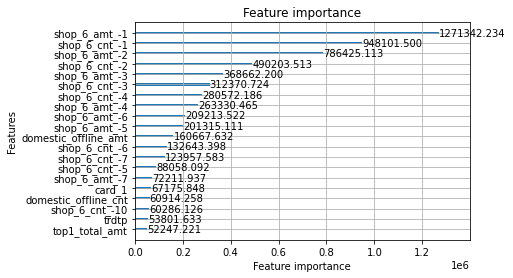

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.490999	valid_1's poisson: 0.492207
[100]	training's poisson: 0.321027	valid_1's poisson: 0.325377
[150]	training's poisson: 0.220315	valid_1's poisson: 0.227736
[200]	training's poisson: 0.15412	valid_1's poisson: 0.164589
[250]	training's poisson: 0.109073	valid_1's poisson: 0.123239
[300]	training's poisson: 0.0749575	valid_1's poisson: 0.0924268
[350]	training's poisson: 0.0496208	valid_1's poisson: 0.0706475
[400]	training's poisson: 0.0296381	valid_1's poisson: 0.0541759
[450]	training's poisson: 0.0133146	valid_1's poisson: 0.0413625
[500]	training's poisson: 0.000726477	valid_1's poisson: 0.0323737
[550]	training's poisson: -0.00968591	valid_1's poisson: 0.0257344
[600]	training's poisson: -0.0188294	valid_1's poisson: 0.0205587
[650]	training's poisson: -0.0267371	valid_1's poisson: 0.0162736
[700]	training's poisson: -0.0337887	valid_1's poisson: 0.0129702
[750]	training's poisson: -0.0402

<Figure size 864x432 with 0 Axes>

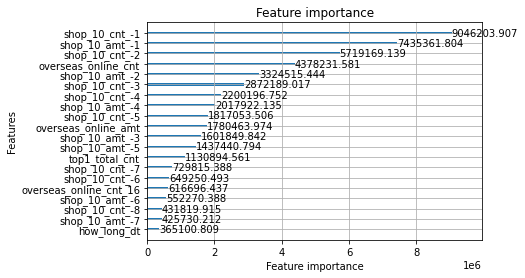

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.345758	valid_1's poisson: 0.345196
[100]	training's poisson: 0.308626	valid_1's poisson: 0.309401
[150]	training's poisson: 0.286853	valid_1's poisson: 0.288827
[200]	training's poisson: 0.272811	valid_1's poisson: 0.276002
[250]	training's poisson: 0.262804	valid_1's poisson: 0.267182
[300]	training's poisson: 0.255253	valid_1's poisson: 0.260812
[350]	training's poisson: 0.249669	valid_1's poisson: 0.256472
[400]	training's poisson: 0.245228	valid_1's poisson: 0.253244
[450]	training's poisson: 0.241644	valid_1's poisson: 0.250923
[500]	training's poisson: 0.238642	valid_1's poisson: 0.249184
[550]	training's poisson: 0.236068	valid_1's poisson: 0.247893
[600]	training's poisson: 0.233834	valid_1's poisson: 0.24693
[650]	training's poisson: 0.231898	valid_1's poisson: 0.246224
[700]	training's poisson: 0.230143	valid_1's poisson: 0.24567
[750]	training's poisson: 0.228568	valid_1's poisson: 0.245

<Figure size 864x432 with 0 Axes>

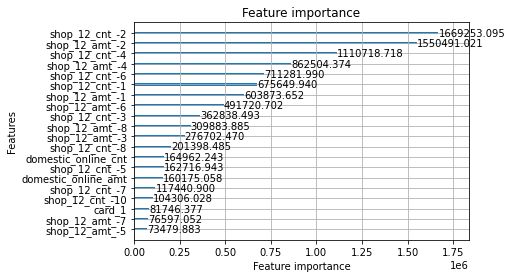

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.305896	valid_1's poisson: 0.318413
[100]	training's poisson: 0.161728	valid_1's poisson: 0.178877
[150]	training's poisson: 0.0826776	valid_1's poisson: 0.103342
[200]	training's poisson: 0.028395	valid_1's poisson: 0.0513906
[250]	training's poisson: -0.00948821	valid_1's poisson: 0.0157655
[300]	training's poisson: -0.0371346	valid_1's poisson: -0.0097463
[350]	training's poisson: -0.0574488	valid_1's poisson: -0.0276199
[400]	training's poisson: -0.0734736	valid_1's poisson: -0.0411412
[450]	training's poisson: -0.0855136	valid_1's poisson: -0.0502142
[500]	training's poisson: -0.0959439	valid_1's poisson: -0.0580728
[550]	training's poisson: -0.104857	valid_1's poisson: -0.0643937
[600]	training's poisson: -0.112121	valid_1's poisson: -0.0688075
[650]	training's poisson: -0.118542	valid_1's poisson: -0.0725364
[700]	training's poisson: -0.124382	valid_1's poisson: -0.0755232
[750]	training's po

<Figure size 864x432 with 0 Axes>

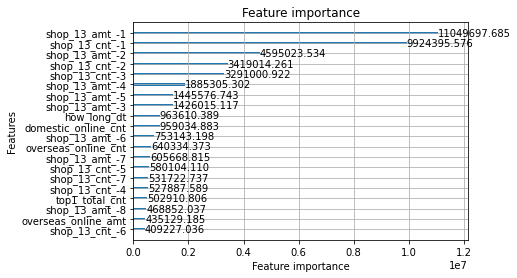

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.543163	valid_1's poisson: 0.551989
[100]	training's poisson: 0.351321	valid_1's poisson: 0.364515
[150]	training's poisson: 0.241191	valid_1's poisson: 0.257594
[200]	training's poisson: 0.167994	valid_1's poisson: 0.187321
[250]	training's poisson: 0.117966	valid_1's poisson: 0.140063
[300]	training's poisson: 0.0807029	valid_1's poisson: 0.105501
[350]	training's poisson: 0.0543536	valid_1's poisson: 0.0819304
[400]	training's poisson: 0.0344403	valid_1's poisson: 0.0647943
[450]	training's poisson: 0.0193372	valid_1's poisson: 0.0525261
[500]	training's poisson: 0.00751379	valid_1's poisson: 0.0435131
[550]	training's poisson: -0.0023748	valid_1's poisson: 0.0364381
[600]	training's poisson: -0.0101395	valid_1's poisson: 0.0314635
[650]	training's poisson: -0.0167986	valid_1's poisson: 0.0276735
[700]	training's poisson: -0.0225233	valid_1's poisson: 0.024834
[750]	training's poisson: -0.0275871

<Figure size 864x432 with 0 Axes>

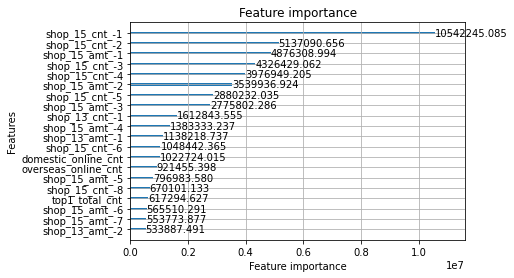

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.265689	valid_1's poisson: 0.264178
[100]	training's poisson: 0.246327	valid_1's poisson: 0.246653
[150]	training's poisson: 0.234087	valid_1's poisson: 0.236075
[200]	training's poisson: 0.225859	valid_1's poisson: 0.229392
[250]	training's poisson: 0.219845	valid_1's poisson: 0.224922
[300]	training's poisson: 0.215081	valid_1's poisson: 0.221659
[350]	training's poisson: 0.211304	valid_1's poisson: 0.219367
[400]	training's poisson: 0.208163	valid_1's poisson: 0.21766
[450]	training's poisson: 0.205509	valid_1's poisson: 0.216435
[500]	training's poisson: 0.203223	valid_1's poisson: 0.215548
[550]	training's poisson: 0.201146	valid_1's poisson: 0.214861
[600]	training's poisson: 0.199304	valid_1's poisson: 0.214349
[650]	training's poisson: 0.197648	valid_1's poisson: 0.21394
[700]	training's poisson: 0.196096	valid_1's poisson: 0.213617
[750]	training's poisson: 0.194748	valid_1's poisson: 0.213

<Figure size 864x432 with 0 Axes>

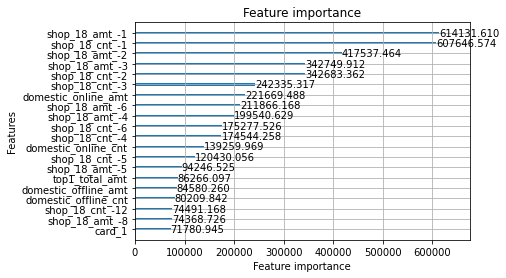

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.375077	valid_1's poisson: 0.377507
[100]	training's poisson: 0.35256	valid_1's poisson: 0.356676
[150]	training's poisson: 0.338015	valid_1's poisson: 0.343871
[200]	training's poisson: 0.327859	valid_1's poisson: 0.335482
[250]	training's poisson: 0.320226	valid_1's poisson: 0.329637
[300]	training's poisson: 0.314364	valid_1's poisson: 0.325491
[350]	training's poisson: 0.309597	valid_1's poisson: 0.322505
[400]	training's poisson: 0.305664	valid_1's poisson: 0.320307
[450]	training's poisson: 0.302306	valid_1's poisson: 0.318642
[500]	training's poisson: 0.299393	valid_1's poisson: 0.317409
[550]	training's poisson: 0.296828	valid_1's poisson: 0.316498
[600]	training's poisson: 0.294481	valid_1's poisson: 0.315758
[650]	training's poisson: 0.292321	valid_1's poisson: 0.315187
[700]	training's poisson: 0.290306	valid_1's poisson: 0.314713
[750]	training's poisson: 0.288487	valid_1's poisson: 0.31

<Figure size 864x432 with 0 Axes>

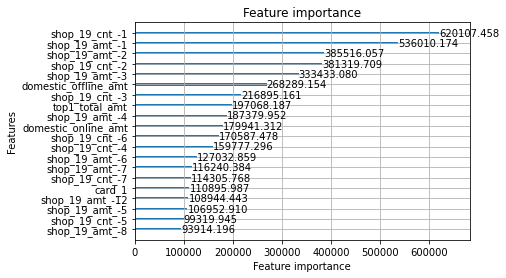

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.288796	valid_1's poisson: 0.291521
[100]	training's poisson: 0.269766	valid_1's poisson: 0.274678
[150]	training's poisson: 0.257564	valid_1's poisson: 0.264549
[200]	training's poisson: 0.249007	valid_1's poisson: 0.258046
[250]	training's poisson: 0.242498	valid_1's poisson: 0.253498
[300]	training's poisson: 0.237372	valid_1's poisson: 0.250346
[350]	training's poisson: 0.233201	valid_1's poisson: 0.248067
[400]	training's poisson: 0.229668	valid_1's poisson: 0.246417
[450]	training's poisson: 0.226565	valid_1's poisson: 0.245146
[500]	training's poisson: 0.223836	valid_1's poisson: 0.244211
[550]	training's poisson: 0.221421	valid_1's poisson: 0.243502
[600]	training's poisson: 0.219209	valid_1's poisson: 0.24296
[650]	training's poisson: 0.217202	valid_1's poisson: 0.242547
[700]	training's poisson: 0.215383	valid_1's poisson: 0.242229
[750]	training's poisson: 0.213694	valid_1's poisson: 0.24

<Figure size 864x432 with 0 Axes>

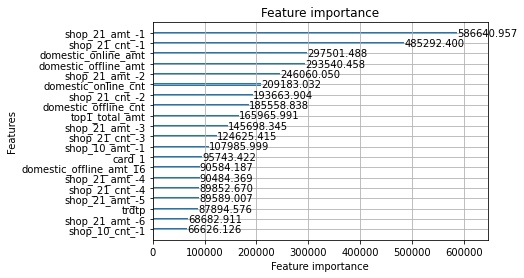

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.234634	valid_1's poisson: 0.233273
[100]	training's poisson: 0.214199	valid_1's poisson: 0.21372
[150]	training's poisson: 0.202208	valid_1's poisson: 0.20279
[200]	training's poisson: 0.194171	valid_1's poisson: 0.195877
[250]	training's poisson: 0.188258	valid_1's poisson: 0.19108
[300]	training's poisson: 0.183776	valid_1's poisson: 0.187697
[350]	training's poisson: 0.18021	valid_1's poisson: 0.185254
[400]	training's poisson: 0.177217	valid_1's poisson: 0.183338
[450]	training's poisson: 0.174793	valid_1's poisson: 0.182025
[500]	training's poisson: 0.172673	valid_1's poisson: 0.181015
[550]	training's poisson: 0.170745	valid_1's poisson: 0.180221
[600]	training's poisson: 0.169025	valid_1's poisson: 0.179585
[650]	training's poisson: 0.167422	valid_1's poisson: 0.179085
[700]	training's poisson: 0.166012	valid_1's poisson: 0.178721
[750]	training's poisson: 0.164724	valid_1's poisson: 0.17844

<Figure size 864x432 with 0 Axes>

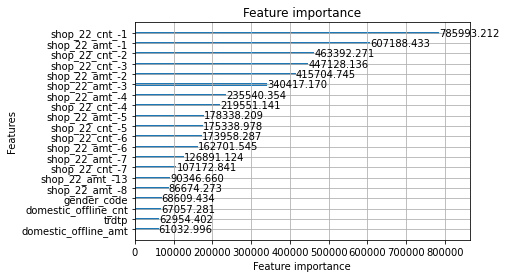

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.288963	valid_1's poisson: 0.291927
[100]	training's poisson: 0.26453	valid_1's poisson: 0.268752
[150]	training's poisson: 0.249818	valid_1's poisson: 0.255464
[200]	training's poisson: 0.239563	valid_1's poisson: 0.24667
[250]	training's poisson: 0.232358	valid_1's poisson: 0.240985
[300]	training's poisson: 0.226868	valid_1's poisson: 0.236967
[350]	training's poisson: 0.222493	valid_1's poisson: 0.234073
[400]	training's poisson: 0.218983	valid_1's poisson: 0.232001
[450]	training's poisson: 0.215997	valid_1's poisson: 0.230476
[500]	training's poisson: 0.213439	valid_1's poisson: 0.229349
[550]	training's poisson: 0.211171	valid_1's poisson: 0.228508
[600]	training's poisson: 0.209135	valid_1's poisson: 0.227877
[650]	training's poisson: 0.20729	valid_1's poisson: 0.227388
[700]	training's poisson: 0.205606	valid_1's poisson: 0.227038
[750]	training's poisson: 0.204073	valid_1's poisson: 0.2267

<Figure size 864x432 with 0 Axes>

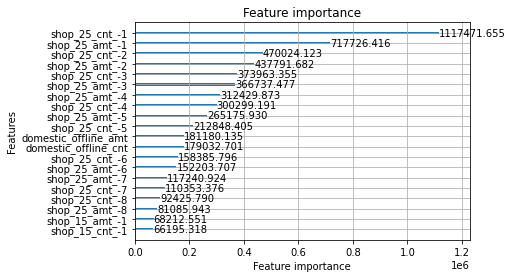

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.190998	valid_1's poisson: 0.194584
[100]	training's poisson: 0.173609	valid_1's poisson: 0.178618
[150]	training's poisson: 0.163464	valid_1's poisson: 0.169855
[200]	training's poisson: 0.156656	valid_1's poisson: 0.164348
[250]	training's poisson: 0.151661	valid_1's poisson: 0.160634
[300]	training's poisson: 0.147838	valid_1's poisson: 0.15804
[350]	training's poisson: 0.144807	valid_1's poisson: 0.156272
[400]	training's poisson: 0.142266	valid_1's poisson: 0.155037
[450]	training's poisson: 0.140035	valid_1's poisson: 0.154024
[500]	training's poisson: 0.138093	valid_1's poisson: 0.153287
[550]	training's poisson: 0.136399	valid_1's poisson: 0.152757
[600]	training's poisson: 0.134821	valid_1's poisson: 0.152369
[650]	training's poisson: 0.133381	valid_1's poisson: 0.152072
[700]	training's poisson: 0.131955	valid_1's poisson: 0.151845
[750]	training's poisson: 0.130745	valid_1's poisson: 0.15

<Figure size 864x432 with 0 Axes>

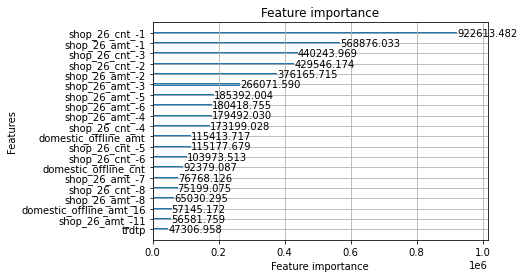

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.0307408	valid_1's poisson: 0.0329586
[100]	training's poisson: -0.327888	valid_1's poisson: -0.323291
[150]	training's poisson: -0.537652	valid_1's poisson: -0.530649
[200]	training's poisson: -0.673048	valid_1's poisson: -0.66361
[250]	training's poisson: -0.770816	valid_1's poisson: -0.759032
[300]	training's poisson: -0.839267	valid_1's poisson: -0.825065
[350]	training's poisson: -0.890873	valid_1's poisson: -0.874236
[400]	training's poisson: -0.9278	valid_1's poisson: -0.908429
[450]	training's poisson: -0.956776	valid_1's poisson: -0.934679
[500]	training's poisson: -0.97965	valid_1's poisson: -0.954758
[550]	training's poisson: -0.997173	valid_1's poisson: -0.969356
[600]	training's poisson: -1.01209	valid_1's poisson: -0.981358
[650]	training's poisson: -1.02402	valid_1's poisson: -0.990398
[700]	training's poisson: -1.03385	valid_1's poisson: -0.997293
[750]	training's poisson: -1.04158	v

<Figure size 864x432 with 0 Axes>

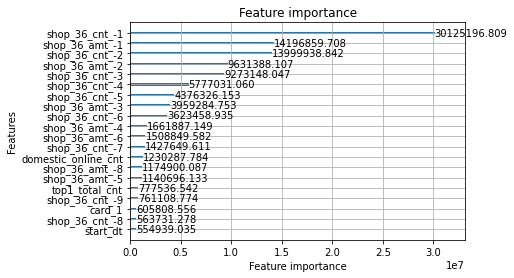

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.601607	valid_1's poisson: 0.600103
[100]	training's poisson: 0.420645	valid_1's poisson: 0.420256
[150]	training's poisson: 0.310217	valid_1's poisson: 0.311472
[200]	training's poisson: 0.238272	valid_1's poisson: 0.241448
[250]	training's poisson: 0.189238	valid_1's poisson: 0.194526
[300]	training's poisson: 0.153277	valid_1's poisson: 0.160676
[350]	training's poisson: 0.127496	valid_1's poisson: 0.137095
[400]	training's poisson: 0.107512	valid_1's poisson: 0.119323
[450]	training's poisson: 0.0928339	valid_1's poisson: 0.106863
[500]	training's poisson: 0.0813232	valid_1's poisson: 0.0976835
[550]	training's poisson: 0.0717704	valid_1's poisson: 0.0903723
[600]	training's poisson: 0.0641594	valid_1's poisson: 0.0850969
[650]	training's poisson: 0.0578141	valid_1's poisson: 0.0810689
[700]	training's poisson: 0.0526328	valid_1's poisson: 0.0781667
[750]	training's poisson: 0.0479974	valid_1's 

<Figure size 864x432 with 0 Axes>

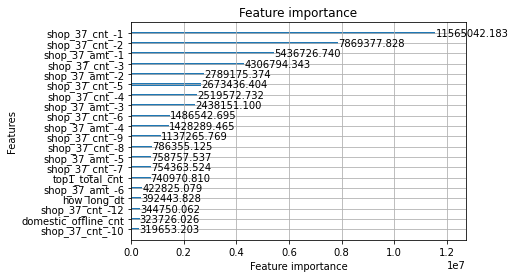

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.209827	valid_1's poisson: 0.210322
[100]	training's poisson: 0.194536	valid_1's poisson: 0.196844
[150]	training's poisson: 0.184835	valid_1's poisson: 0.188808
[200]	training's poisson: 0.178003	valid_1's poisson: 0.183561
[250]	training's poisson: 0.172858	valid_1's poisson: 0.179921
[300]	training's poisson: 0.168834	valid_1's poisson: 0.177344
[350]	training's poisson: 0.165484	valid_1's poisson: 0.175432
[400]	training's poisson: 0.162711	valid_1's poisson: 0.174044
[450]	training's poisson: 0.160292	valid_1's poisson: 0.17299
[500]	training's poisson: 0.158189	valid_1's poisson: 0.172195
[550]	training's poisson: 0.156328	valid_1's poisson: 0.171601
[600]	training's poisson: 0.154609	valid_1's poisson: 0.171134
[650]	training's poisson: 0.153048	valid_1's poisson: 0.170786
[700]	training's poisson: 0.151648	valid_1's poisson: 0.170513
[750]	training's poisson: 0.150355	valid_1's poisson: 0.17

<Figure size 864x432 with 0 Axes>

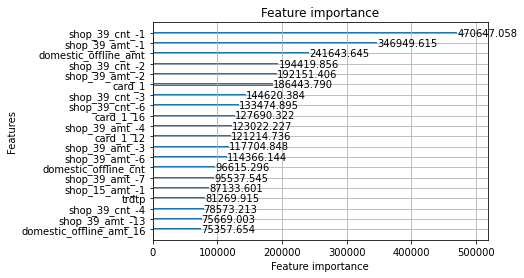

Training until validation scores don't improve for 100 rounds
[50]	training's poisson: 0.506949	valid_1's poisson: 0.516448
[100]	training's poisson: 0.399919	valid_1's poisson: 0.414339
[150]	training's poisson: 0.337969	valid_1's poisson: 0.355688
[200]	training's poisson: 0.296876	valid_1's poisson: 0.317266
[250]	training's poisson: 0.268857	valid_1's poisson: 0.29172
[300]	training's poisson: 0.24878	valid_1's poisson: 0.274021
[350]	training's poisson: 0.233499	valid_1's poisson: 0.261058
[400]	training's poisson: 0.221794	valid_1's poisson: 0.251578
[450]	training's poisson: 0.212649	valid_1's poisson: 0.244729
[500]	training's poisson: 0.205406	valid_1's poisson: 0.23975
[550]	training's poisson: 0.199321	valid_1's poisson: 0.235871
[600]	training's poisson: 0.194019	valid_1's poisson: 0.232829
[650]	training's poisson: 0.189452	valid_1's poisson: 0.230526
[700]	training's poisson: 0.185428	valid_1's poisson: 0.228753
[750]	training's poisson: 0.181819	valid_1's poisson: 0.2272

<Figure size 864x432 with 0 Axes>

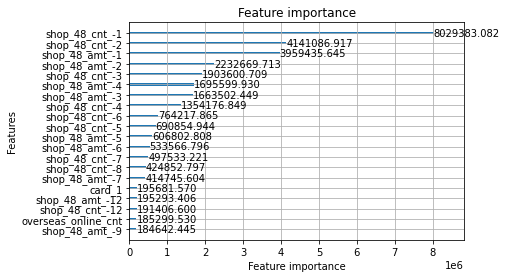

In [20]:
results = {a_cate: [] for a_cate in cnt_handler.ylabels}
train_results = {a_cate: [] for a_cate in cnt_handler.ylabels}

for fold, (trn_ind, val_ind) in enumerate(idx_results):
    print(f'Training fold {fold + 1}')
    for ylabel in cnt_handler.ylabels:
        col_name = ylabel

        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(cnt_test))
        results[ylabel].append(result)

In [21]:
loader.save_data([results, train_results, idx_results],
                 '2021_12_27_cnt_poisson_train_results.joblib',
                 'generate cnt_poisson train results')
